### Custom ML model to identify local similarities ("links") with sequence profiles

Let $$X \in \{0,1\}^{B\times N\times 6 \times T \times 21}$$ be a batch of **one-hot encoded input translated sequences**,
where $B$ is `batch_size`, $N$ is the number of genomes and $T$ is the `tile_size` (in aa).
The 6 is here the number of translated frames in order (0,+),(1,+),(2,+),(0,-),(1,-),(2,-).
The 21 is here the size of the considered amino acid alphabet.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow as tf
import logomaker
from time import time
from tqdm import tqdm
from IPython.display import Audio

import importlib
import sequtils as su
print(importlib.reload(su))
import seq
print(importlib.reload(seq))
import dataset as dsg
print(importlib.reload(dsg))

print(tf.__version__)

%load_ext memory_profiler

<module 'sequtils' from '/home/matthis/genomegraph/learn_specific_profiles/sequtils.py'>
<module 'seq' from '/home/matthis/genomegraph/learn_specific_profiles/seq.py'>
<module 'dataset' from '/home/matthis/genomegraph/learn_specific_profiles/dataset.py'>
2.3.1


### Create random genomes as toy data 

In [2]:
N = 8            # number of genomes
tile_size = 334  # tile size measured in amino acids
# A tile is a consecutive subsequence of _one_ contig/scaffold/chromosome.
# Tiles should be about gene-sized.

#genome_sizes = [[210,100], [30,220,150], [230,110,120,90], [180]] # in nucleotides
#insertPatterns = ["ATGATGATG", "CCCCCCCCCCCC"]
#genomes = seq.getRandomGenomes(N, genome_sizes, insertPatterns, mutationProb=0.2, verbose=True)

genome_sizes = [[10000]] * N
                # in nucleotides
insertPatterns = ["ATGGCAAGAATTCAATCTACTGCAAATAAAGAA",
                 ] 
repeatPatterns = ['AGAGAACCTGAAGCTACTGCTGAACCTGAAAGA']
genomes, repeatTracking, insertTracking = seq.getRandomGenomes(N, genome_sizes, insertPatterns,
                                                               repeatPatterns,
                                                               mutationProb=0.0, 
                                                               repeatMultiple=range(0,1),
                                                               repeatInsert=range(10,11),
                                                               verbose=False)
print(insertTracking)

{0: {0: {'pos': [102], 'pattern': ['ATGGCAAGAATTCAATCTACTGCAAATAAAGAA']}}, 1: {0: {'pos': [6007], 'pattern': ['ATGGCAAGAATTCAATCTACTGCAAATAAAGAA']}}, 2: {0: {'pos': [886], 'pattern': ['ATGGCAAGAATTCAATCTACTGCAAATAAAGAA']}}, 3: {0: {'pos': [5360], 'pattern': ['ATGGCAAGAATTCAATCTACTGCAAATAAAGAA']}}, 4: {0: {'pos': [7767], 'pattern': ['ATGGCAAGAATTCAATCTACTGCAAATAAAGAA']}}, 5: {0: {'pos': [6270], 'pattern': ['ATGGCAAGAATTCAATCTACTGCAAATAAAGAA']}}, 6: {0: {'pos': [8394], 'pattern': ['ATGGCAAGAATTCAATCTACTGCAAATAAAGAA']}}, 7: {0: {'pos': [2077], 'pattern': ['ATGGCAAGAATTCAATCTACTGCAAATAAAGAA']}}}


In [3]:
def printExpectedPatterns():
    desiredPatternAA, repeatPatternAA = None, None
    if insertPatterns is not None:
        desiredPatternAA = []
        for pattern in insertPatterns:
            desiredPatternAA.extend(su.six_frame_translation(pattern))

        print("Desired:", desiredPatternAA)

    if repeatPatterns is not None:
        repeatPatternAA = []
        for pattern in repeatPatterns:
            repeatPatternAA.extend(su.six_frame_translation(pattern))

        print("Repeat:", repeatPatternAA)
        
    return desiredPatternAA, repeatPatternAA

desiredPatternAA, repeatPatternAA = printExpectedPatterns()

Desired: ['MARIQSTANKE', 'WQEFNLLQIK', 'GKNSIYCK*R', 'FFICSRLNSCH', 'SLFAVD*ILA', 'LYLQ*IEFLP']
Repeat: ['REPEATAEPER', 'ENLKLLLNLK', 'RT*SYC*T*K', 'SFRFSSSFRFS', 'LSGSAVASGS', 'FQVQQ*LQVL']


---

#### Interlude: Magic Commands

https://towardsdatascience.com/speed-up-jupyter-notebooks-20716cbe2025

`%time command` prints runtime of command  
`%prun command` profiler for command, what steps take how much time? Adds overhead  
`%memit command` peak memory usage and memory increment  
`%mprun command` memory profiling

---

In [4]:
# Load Real Data
if False:
    from Bio import SeqIO
    import os
    
    files = ['hg38.fa', 'mm10.fa', 'hetGla2.fa', 'macFas5.fa']
    genomes = [[] for _ in range(len(files))]
    datapath = "/nas-hs/projs/seedFinding/data/20210517_flanked/"
    def loadRealGenomes(genomes=genomes):
        for i in range(len(files)):
            genomes[i].extend([str(seq.seq) for seq in SeqIO.parse(os.path.join(datapath, files[i]), 'fasta')])
            
    %memit loadRealGenomes()
    
    # load pickled Q to safe time
    Qfile = os.path.join(datapath, "backgroundAAFreqs.pkl4")
    if not os.path.isfile(Qfile):
        print("Getting Q")
        %time Q = seq.backGroundAAFreqs(genomes, True)
        with open(Qfile, 'wb') as fh:
            pickle.dump(Q, fh, protocol=4)
            
    else:
        with open(Qfile, 'rb') as fh:
            Q = pickle.load(fh)
    
else:
    %time Q = seq.backGroundAAFreqs(genomes, True)

background freqs:  159968.0 *
C 0.0307
K 0.0309
E 0.0313
W 0.0160
T 0.0620
G 0.0630
Y 0.0311
A 0.0620
I 0.0473
N 0.0312
V 0.0620
H 0.0316
S 0.0938
D 0.0317
F 0.0310
M 0.0163
R 0.0932
L 0.0933
P 0.0630
Q 0.0314
* 0.0470
CPU times: user 128 ms, sys: 0 ns, total: 128 ms
Wall time: 124 ms


For seedFinding data on gs3

    background freqs:  765611260.0 *
    C 0.0329
    K 0.0412
    E 0.0332
    W 0.0165
    T 0.0578
    G 0.0558
    Y 0.0334
    A 0.0510
    I 0.0546
    N 0.0361
    V 0.0578
    H 0.0321
    S 0.0929
    D 0.0280
    F 0.0406
    M 0.0172
    R 0.0710
    L 0.1039
    P 0.0558
    Q 0.0352
    * 0.0527
    CPU times: user 7min 14s, sys: 1.69 s, total: 7min 16s
    Wall time: 7min 16s

In [5]:
print(len(genomes), len(genomes[0]), len(genomes[0][0]))

8 1 10000


In [6]:
# uniform background distribution appears to be rather better
Q = np.ones(21, dtype=np.float32)/21

#### Read in the genome

In [7]:
genomes[0][0][0:100]

'TGTCTCGGATATCAGTCGTCAGCTGGCGCACAATATACACCACATGTTCACGTCAAGACTTTAGCTATGACATTTCTGCCCATCTACAGATTAGCCGGCA'

In [8]:
dsg.testGenerator(genomes, 5, tile_size, 50000)

[INFO] >>> Test genome lengths: [10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]


2it [00:02,  1.41s/it]

[INFO] >>> testGenerator: All good


In [9]:
genome_sizes = [sum([len(s) for s in genome]) for genome in genomes]
batch_size = 1  # number of X to generate per batch
tiles_per_X = 13 # number of tiles per X (-> X.shape[0])
steps_per_epoch = max(1, np.mean(genome_sizes) // (batch_size*tiles_per_X*tile_size*3))
print(genome_sizes, " -> ", steps_per_epoch)

[10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]  ->  1


In [10]:
def getDataset(tiles_per_X: int = tiles_per_X,
               tile_size: int = tile_size,
               genomes = genomes,
               withPosTracking: bool = False):
    if withPosTracking:
        ds = tf.data.Dataset.from_generator(
            dsg.createBatch,
            args = (tf.constant(tiles_per_X), tf.constant(tile_size), tf.constant(genomes, dtype=tf.string), 
                    tf.constant(True)),

            # vvv used in newer versions of TF vvv
            # output_signature = (tf.TensorSpec(shape = ([batch_size, len(genomes), 6, tile_size, su.aa_alphabet_size], 
            #                                            [batch_size, len(genomes), 2]),
            #                                   dtype = (tf.float32, tf.int32))

            # vvv deprecated in newer versions of TF vvv
            output_types = (tf.float32, tf.int32),
            output_shapes = (tf.TensorShape([tiles_per_X, len(genomes), 6, tile_size, su.aa_alphabet_size]),
                             tf.TensorShape([tiles_per_X, len(genomes), 3]))
        )
    else:
        ds = tf.data.Dataset.from_generator(
            dsg.createBatch,
            args = (tf.constant(tiles_per_X), tf.constant(tile_size), tf.constant(genomes, dtype=tf.string), 
                    tf.constant(False)),

            # vvv used in newer versions of TF vvv
            # output_signature = (tf.TensorSpec(shape = [batch_size, len(genomes), 6, tile_size, su.aa_alphabet_size],
            #                                   dtype = tf.float32))

            # vvv deprecated in newer versions of TF vvv
            output_types = (tf.float32),
            output_shapes = (tf.TensorShape([tiles_per_X, len(genomes), 6, tile_size, su.aa_alphabet_size]))
        )
    return ds

---

#### Plot Functions

In [11]:
def plotLogo(P, idxarray = None, pScores = None, max_print=5, label="score"):
    """
    max_print  print up to this many logos
    """
    dfs = su.makeDFs(P.numpy())
    for i in range(min(U,max_print)):
        j = idxarray[i] if idxarray is not None else i
        profile_df = dfs[j]
        logo = logomaker.Logo(profile_df, vpad=.1, width=1)
        logo.style_xticks(anchor=0, spacing=1, rotation=45)
        logo.ax.set_ylabel('information (bits)')
        logo.ax.set_title(f"Profile {j}" + (f" {label}={pScores[j]:.3f}") if pScores is not None else "")

In [12]:
# plot the training history as loss and accuracy curves
def plotHistory(history):
    loss = history['loss']
    Rmax = history['Rmax']
    Rmin = history['Rmin']
    Smax = history['Smax']
    Smin = history['Smin']
    epochs = range(1, len(loss) + 1)

    fig, ax = plt.subplots(ncols = 2, figsize = (15, 6))
    ax[0].plot(epochs, loss, 'bo', label = 'Training loss')
    ax[0].set_title('Training loss')
    ax[0].legend()

    ax[1].plot(epochs, Rmax, 'bo', label = 'Rmax')
    ax[1].plot(epochs, Rmin, 'b+', label = 'Rmin')
    ax[1].plot(epochs, Smax, 'go', label = 'Smax')
    ax[1].plot(epochs, Smin, 'g+', label = 'Smin')
    ax[1].set_title('Training R and S')
    ax[1].legend();
    
    return fig, ax

## TensorFlow Model
Let $$P = (P[w,c,u]) \in [0,1]^{k \times 21 \times U}$$
be a collection of $U$ amino acid **profiles**, each of length $k$.
Let $$ Q = (Q[c]) \in [0,1]^{21}$$ be a background amino acid distribution.

Both are normalized distributions:
$$ \sum_c P[w,c,u] = \sum_c Q[c] = 1 \qquad \forall u,w.$$

Define the scores tensor 
$$ S \in \mathbb{R}^ {B\times N \times U}$$
by
$$ S[b,g,u] = \max_{f=0}^5 \max_{v=0}^{T-k} \sum_{w=0}^{k-1} \sum_{c=0}^{20} X[b,g,f,v+w,c] \cdot \ln \frac {P[w,c,u]}{Q[c]}.$$

For a given batch $S[b,g,u]$ is the maximal score that the $u$-th profile scores in the $b$-th tile of genome $g$.
It can be computed using a **one dimensional convolution** and max pooling.

Define the intermediate variables:

$R \in [0,1]^{k \times 21 \times U}$ by 
$$ R[w,c,u] := \ln \frac {P[w,c,u]}{Q[c]}.$$

$Z \in \mathbb{R}^{B\times N \times 6 \times T-k-1\times U}$ by
$$Z[b,g,f,v,u] := \sum_{w=0}^{k-1} \sum_{c=0}^{20} X[b,g,f,v+w,c] \cdot R[w,c,u].$$

**Losses:**
Only the best score counts for each frame and tile. Sum them up.
$$L_1 = - \sum_{b=1}^B \sum_{g=1}^G \sum_{u=1}^U S[b,g,u]$$ 

In [13]:
U = 2000 # number of profiles to train
k = 11 # length of profiles

In [86]:
class SpecificProfile(tf.keras.Model):
    def __init__(self, k, alphabet_size, units, Q, P_logit_init=None, **kwargs):
        super().__init__(**kwargs)
        # P_logit_init = tf.random.normal([k, alphabet_size, units], stddev=.5, dtype=tf.float32, seed=1)
        
        self.Q = Q
        self.k = k
        self.alphabet_size = alphabet_size
        self.units = units
        self.history = {'loss': [],
                        'Rmax': [],
                        'Rmin': [],
                        'Smax': [],
                        'Smin': []}
        
        if P_logit_init is None:
            P_logit_init = self._getRandomProfiles()
        if False: # to test whether the right pattern has low loss
                P_logit_init[:,:,0:2] = -100. #-100 *np.ones([k, 21, 2], dtype=np.float32)
                P_logit_init[0,15,0] = 5 # M
                P_logit_init[1,7,0] = 5 # A
                P_logit_init[2,16,0] = 5 # R
                P_logit_init[3,8,0] = 5 # I
                P_logit_init[4,19,0] = 5 # Q
                P_logit_init[5,12,0] = 5 # S
                P_logit_init[6,4,0] = 5 # T
                P_logit_init[7,7,0] = 5 # A
                P_logit_init[8,9,0] = 5 # N
                P_logit_init[9,1,0] = 5 # K
                P_logit_init[10,2,0] = 5 # E
                # REPEATAEPER
                P_logit_init[0,16,1] = 5 # R
                P_logit_init[1,2,1] = 5 # E
                P_logit_init[2,18,1] = 5 # P
                P_logit_init[3,2,1] = 5 # E
                P_logit_init[4,7,1] = 5 # A
                P_logit_init[5,4,1] = 5 # T
                P_logit_init[6,7,1] = 5 # A
                P_logit_init[7,2,1] = 5 # E
                P_logit_init[8,18,1] = 5 # P
                P_logit_init[9,2,1] = 5 # E
                P_logit_init[10,16,1] = 5 # R
                
        self.setP_logit(P_logit_init)
        
    def _getRandomProfiles(self):
        Q1 = tf.expand_dims(self.Q,0)
        Q2 = tf.expand_dims(Q1,-1)
        
        P_logit_like_Q = np.log(Q2.numpy())
        P_logit_init = P_logit_like_Q + np.random.normal(scale=4., size=[self.k, self.alphabet_size, self.units]).astype('float32')
        return P_logit_init
        
    # return for each profile the best score at any position in the dataset
    def get_profile_match_sites(self, ds, threshold, aa_tile_size, genomes, L5score: bool = False):
        # dict of dicts of dict, for each genome, map each contig to a dict that collects profile indices and positions
        #   (given that the profile matches with score above threshold for that genome, contig and position)
        sites = {}
        for batch in ds:
            assert len(batch) == 2, str(len(batch))+" -- use batch dataset with position tracking!"
            Xb = batch[0]
            posTrackB = batch[1]
            assert len(Xb.shape) == 6, str(Xb.shape)
            assert len(posTrackB.shape) == 4, str(posTrackB.shape)
            assert Xb.shape[0] == posTrackB.shape[0], str(Xb.shape[0])+" != "+str(posTrackB.shape[0])
            for b in range(Xb.shape[0]):
                X = Xb[b]
                posTrack = posTrackB[b]
                #print("[DEBUG] >>> tilesIdx "+str(tilesIdx)+", X:\n", X)
                #print("[DEBUG] >>> tilesIdx "+str(tilesIdx)+", posTrack:\n", posTrack)
                
                # get positions of best profile matches
                _, _, Z = self.call(X)              # (tilePerX, N, 6, T-k+1, U)
                if L5score:
                    gamma = .2
                    Z2 = tf.nn.softmax(gamma*Z, axis=0)
                    Z3 = tf.math.multiply(Z, tf.square(Z2))
                    Z = Z3
                    
                for g in range(X.shape[1]):
                    if tf.reduce_max(Z[:,g,:,:,:]) >= threshold:
                        p = tf.argmax( tf.reduce_max(Z[:,g,:,:,:], axis=[0,1,2]) ).numpy() # index of the profile with best hit
                        t = tf.argmax( tf.reduce_max(Z[:,g,:,:,p], axis=[1,2]) ).numpy()   # index of the tile with best hit
                        f = tf.argmax( tf.reduce_max(Z[t,g,:,:,p], axis=[1]) ).numpy()     # index of the frame with best hit
                        r = tf.argmax( Z[t,g,f,:,p] ).numpy()                              # index of the rel. position with best hit

                        c = posTrack[t,g,0].numpy()
                        assert c >= 0
                        cStart = posTrack[t,g,1].numpy()
                        tilelen = posTrack[t,g,2].numpy()
                        
                        pos = r*3 # to dna coord
                        if f < 3:
                            pos += f # add frame shift
                            pos = cStart + pos
                        else:
                            # add appropriate frame shift
                            seqlen = len(genomes[g][c])
                            if seqlen%3 == tilelen%3:
                                pos += f-3
                            else:
                                pos += dsg.rcFrameOffsets(seqlen)[f-3]
                                
                            pos = tilelen - pos - (self.k*3)

                        if g not in sites:
                            sites[g] = {}
                        if c not in sites[g]:
                            sites[g][c] = {'profile': [], 'pos': [], 'score': [], 'frame': []}

                        sites[g][c]['profile'].append(p)
                        sites[g][c]['pos'].append(pos)
                        sites[g][c]['score'].append(Z[t,g,f,r,p].numpy())
                        sites[g][c]['frame'].append(f)
                        
        return sites

    def getP(self):
        P = tf.nn.softmax(self.P_logit, axis=1, name="P")
        return P
    
    def getR(self):
        P = self.getP()
        Q1 = tf.expand_dims(self.Q,0)
        Q2 = tf.expand_dims(Q1,-1)
        # Limit the odds-ratio, to prevent problem with log(0).
        # Very bad matches of profiles are irrelevant anyways.
        ratio = tf.maximum(P/Q2, 1e-6)
        R = tf.math.log(ratio)
        return R
    
    def getZ(self, X):
        R = self.getR()

        X1 = tf.expand_dims(X,-1) # 1 input channel
        R1 = tf.expand_dims(R,-2) # 1 input channel
        Z1 = tf.nn.conv2d(X1, R1, strides=1,
                          padding='VALID', data_format="NHWC", name="Z")
        Z = tf.squeeze(Z1, 4) # remove input channel dimension
        return Z, R
        
    def call(self, X):
        Z, R = self.getZ(X)

        S = tf.reduce_max(Z, axis=[2,3])
        return S, R, Z

    # custom loss
    def loss(self, S):
        # overall fit of patterns
        # beta = 5.0 # the larger the harder the softmax
        # S1 = tf.math.multiply(S, tf.nn.softmax(beta*S, axis=0)) # a soft version between maximizing and summing over the tiles
        L1 = -tf.reduce_sum(S) / self.units
        
        # homogeneity along pattern
        P = self.getP()
        H = -tf.reduce_sum(tf.math.multiply(P, tf.math.log(P)), axis=1) # entropy
        # standard deviation of entropies
        VH = tf.math.reduce_std(H, axis=0) # variance for each profile along site axis
        L2 = tf.reduce_mean(VH)
        
        # homogeneity between genomes
        # ignore the best score per genome, so that rather others are improved
        # L3 = tf.reduce_sum(tf.reduce_max(S, axis=1)) # cancels out the best occurence from L1
        
        # other ideas: 
        # - std deviation of scores of different genomes
        # L4 = tf.reduce_sum(tf.math.reduce_std(tf.reduce_max(S, axis=0), axis=0))
        # - minimum score of any genome
        
        # penalize multiple similarly good near-best matches in the same genome
        gamma = .2 # a small value means a more inclusive meaning of near-best
        S2 = tf.nn.softmax(gamma*S, axis=0)
        S3 = tf.reduce_max(S2, axis=0) # the closer to 1, the clearer is the champion match a winner
        S4 = tf.reduce_max(S, axis=0) # ranges over tiles, or soft max like in L1
        S5 = tf.math.multiply(S4, tf.square(S3)) # effectively the best score per genome is divided by the number of matches
        loss_by_unit = tf.reduce_sum(-S5, axis=0) / self.units # sum over genomes
        L5 = tf.reduce_sum(loss_by_unit) # sum over profiles=units
        
        #return (L1+L3)/N + 50*L2, L2, L4 # + 100*L2 # (L1 + L3)/N #+ 100*L2
        return L5, loss_by_unit, (L1, L2, (L5, loss_by_unit)) # first: loss to use in training, last: tuple of all losses for evaluation

    # return for each profile the best score at any position in the dataset
    def max_profile_scores(self, ds):
        scores = np.ones([self.units], dtype=np.float32) * -np.infty
        for batch in ds:
            assert len(batch.shape) == 6, str(batch.shape)+" -- use batch dataset without position tracking!"
            for X in batch:
                assert len(X.shape) == 5, str(X.shape)
                S, _, _ = self.call(X)
                scores = np.maximum(np.max(S, axis=(0,1)), scores)
                                    
        return scores
    
    # return for each profile the loss contribution
    def min_profile_losses(self, ds):
        losses = np.zeros([self.units], dtype=np.float32)
        for batch in ds:
            assert len(batch.shape) == 6, str(batch.shape)+" -- use batch dataset without position tracking!"
            for X in batch:
                assert len(X.shape) == 5, str(X.shape)
                S, _, _ = self.call(X)
                _, losses_by_unit, _ = self.loss(S)
                losses += losses_by_unit
                                    
        return losses
    
    @tf.function()
    def train_step(self, X):
        with tf.GradientTape() as tape:
            S, R, _ = self.call(X)
            L, _, _ = self.loss(S)

        grad = tape.gradient(L, self.P_logit)
        self.opt.apply_gradients([(grad, self.P_logit)])
        
        return S, R, L

    def train(self, X, epochs=1000, verbose=True):
        self.opt = tf.keras.optimizers.Adam(learning_rate=.1) # large learning rate is much faster
        for i in range(epochs):
            self.train_step(X)
            if verbose and (i%(100) == 0 or i==epochs-1):
                S, R, _ = self(X)
                L, _, _ = self.loss(S)
                print(f"epoch {i:>5} loss={L.numpy():.4f}" +
                      " max R: {:.3f}".format(tf.reduce_max(R).numpy()) +
                      " min R: {:.3f}".format((tf.reduce_min(R).numpy())))
                
    def train_ds(self, ds, steps_per_epoch, epochs, verbose=True, verbose_freq=100):
        self.opt = tf.keras.optimizers.Adam(learning_rate=1.) # large learning rate is much faster
        tstart = time()
        for i in range(epochs):
            steps = 0
            Lb = []
            Smin, Smax = float('inf'), float('-inf')
            Rmin, Rmax = float('inf'), float('-inf')
            for batch in ds:
                assert len(batch.shape) == 6, str(batch.shape)+" -- use batch dataset without position tracking!"
                for X in batch:
                    assert len(X.shape) == 5, str(X.shape)
                    S, R, L = self.train_step(X)
                    Lb.append(L)
                    Rmax = max(Rmax, tf.reduce_max(R).numpy())
                    Rmin = min(Rmin, tf.reduce_min(R).numpy())
                    Smax = max(Smax, tf.reduce_max(S).numpy())
                    Smin = min(Smin, tf.reduce_min(S).numpy())
                    
                steps += 1
                if steps >= steps_per_epoch:
                    break
                    
            self.history['loss'].append(np.mean(Lb))
            self.history['Rmax'].append(Rmax)
            self.history['Rmin'].append(Rmin)
            self.history['Smax'].append(Smax)
            self.history['Smin'].append(Smin)
                    
            if verbose and (i%(verbose_freq) == 0 or i==epochs-1):
                S, R, _ = self(X)
                L, _, _ = self.loss(S)
                tnow = time()
                print(f"epoch {i:>5} loss={L.numpy():.4f}" +
                      " max R: {:.3f}".format(tf.reduce_max(R).numpy()) +
                      " min R: {:.3f}".format((tf.reduce_min(R).numpy())) +
                      " time: {:.2f}".format(tnow-tstart)) 
                
    def seed_P_ds(self, ds):
        """
            Seed profiles P with profiles that represent units random positions in the input sequences.
            Positions are drawn uniformly from all positions in all sequences. 
            This is done with an old and neat trick online, so that the data has to be read only once.
        """
        rho = 2.0
        oneProfile_logit_like_Q = np.log(self.Q)
        P_logit_init = self._getRandomProfiles() # shape [k, alphabet_size, units]
        m = 0 # number of positions seen so far
        for batch in ds:
            assert len(batch.shape) == 6, str(batch.shape)+" -- use batch dataset without position tracking!"
            for X in batch:
                assert len(X.shape) == 5, str(X.shape)
                X = X.numpy()
                PP = X.reshape([-1, self.alphabet_size]) # (tilesPerX, N, 6, T, alphSize) -> (tilesPerX*N*6*T, alphSize)
                J = PP.shape[0]
                # PP[j,a] is 1 if the j-th character in an artificially concatenated sequence is char a
                # the length k patterns extend over tile ends, which could be improved later
                num_pos = J - self.k
                for j in range(num_pos):
                    i = -1 # i-th profile is to be replaced, unless i<0
                    if m < self.units:
                        i = m
                    elif np.random.choice(m) < self.units:
                        i = np.random.choice(self.units)
                    if i >= 0:
                        # replace i-th profile with a seed profile build from the pattern starting at position j
                        # Seed is the background distribution, except the observed k-mer at pos j is more likely
                        seed = rho * PP[j:j+self.k,:] + oneProfile_logit_like_Q
                        P_logit_init[:,:,i] = seed
                        # print (f"replacing {i:>3}-th pattern with the one from pos {j:>6}:\n", seed)
                    m += 1

        return P_logit_init
                
    def setP_logit(self, P_logit_init):
        self.P_logit = tf.Variable(P_logit_init, trainable=True, name="P_logit") 

In [87]:
# build and randomly initialize profile model
tf.keras.backend.clear_session() # avoid memory cluttering by remains of old models
%time %memit specProModel = SpecificProfile(k, su.aa_alphabet_size, U, Q)

peak memory: 2150.64 MiB, increment: 0.10 MiB
CPU times: user 380 ms, sys: 192 ms, total: 572 ms
Wall time: 876 ms


In [88]:
if False:
    P_init = specProModel.getP()
    plotLogo(P_init)

### Training Set

In [89]:
ds = getDataset().repeat().batch(batch_size).prefetch(150)
ds_score = getDataset().batch(batch_size).prefetch(150)
ds_init  = getDataset().batch(batch_size).prefetch(150)

In [90]:
P_logit_init = specProModel.seed_P_ds(ds_init)
specProModel.setP_logit(P_logit_init)

### Training

    Training on seedFinding data takes 5.5 h for 10 epochs on greifserv3

In [91]:
start = time()
specProModel.train_ds(ds, steps_per_epoch, epochs=10, verbose_freq=1)
end = time()
print(f"time: {end-start:.2f}")

epoch     0 loss=-26.1696 max R: 2.726 min R: -1.617 time: 2.97
epoch     1 loss=-47.7784 max R: 2.993 min R: -3.278 time: 4.95
epoch     2 loss=-66.1774 max R: 3.035 min R: -5.064 time: 6.74
epoch     3 loss=-81.8230 max R: 3.043 min R: -6.854 time: 8.48
epoch     4 loss=-95.6514 max R: 3.044 min R: -8.710 time: 10.27
epoch     5 loss=-107.0114 max R: 3.044 min R: -10.621 time: 12.19
epoch     6 loss=-114.4989 max R: 3.045 min R: -12.445 time: 13.99
epoch     7 loss=-120.0434 max R: 3.045 min R: -13.816 time: 15.70
epoch     8 loss=-124.5512 max R: 3.045 min R: -13.816 time: 17.60
epoch     9 loss=-127.3376 max R: 3.045 min R: -13.816 time: 19.41
time: 19.41


(<Figure size 1080x432 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Training loss'}>,
        <AxesSubplot:title={'center':'Training R and S'}>], dtype=object))

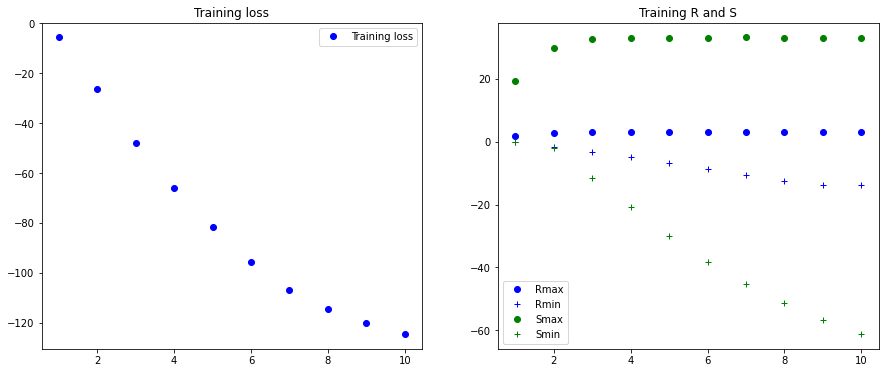

In [92]:
plotHistory(specProModel.history)

### Visualize resulting profiles as sequence logos

In [93]:
_, _ = printExpectedPatterns()

Desired: ['MARIQSTANKE', 'WQEFNLLQIK', 'GKNSIYCK*R', 'FFICSRLNSCH', 'SLFAVD*ILA', 'LYLQ*IEFLP']
Repeat: ['REPEATAEPER', 'ENLKLLLNLK', 'RT*SYC*T*K', 'SFRFSSSFRFS', 'LSGSAVASGS', 'FQVQQ*LQVL']


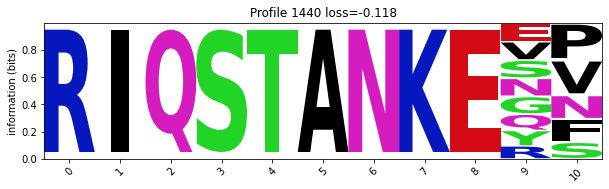

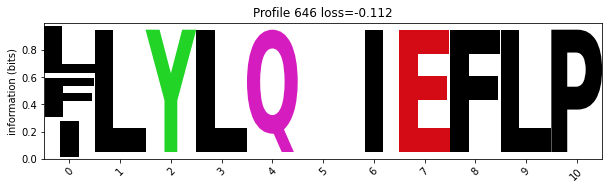

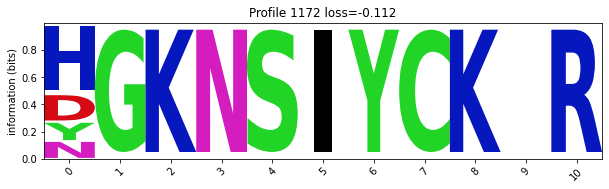

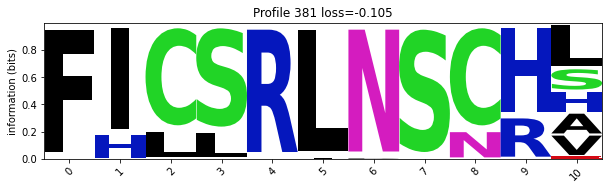

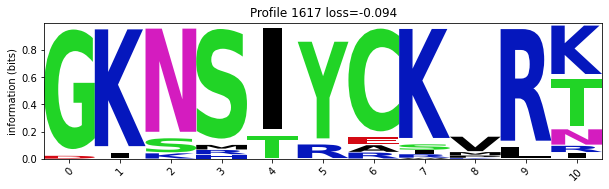

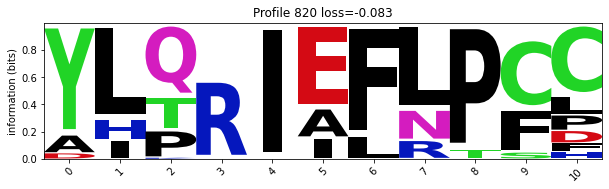

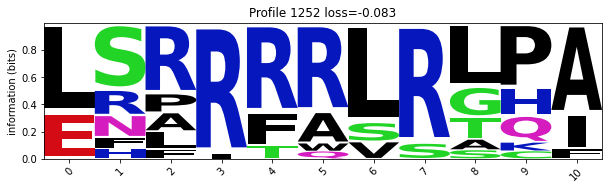

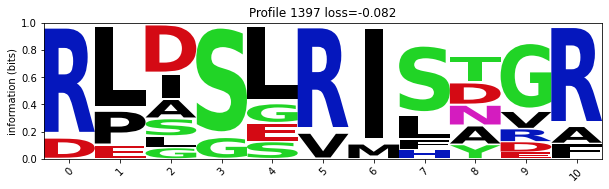

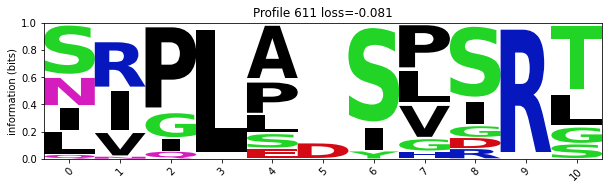

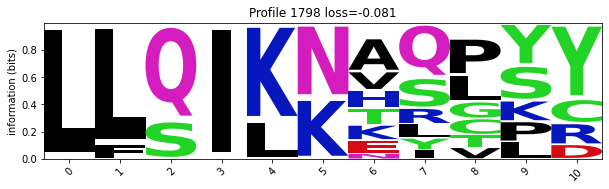

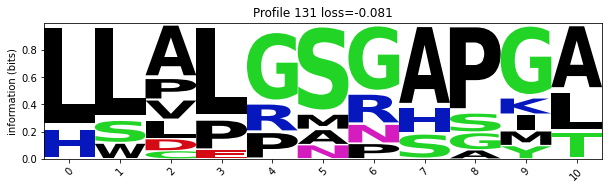

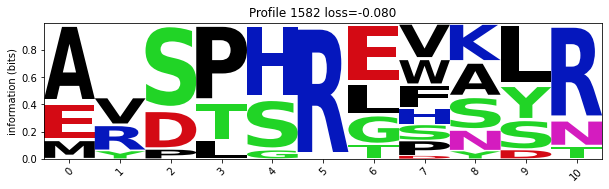

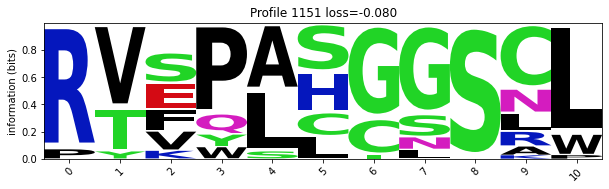

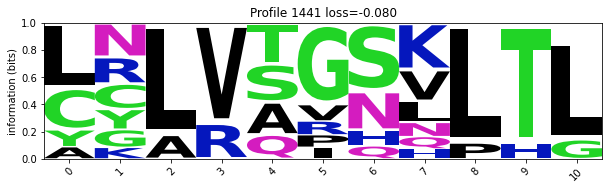

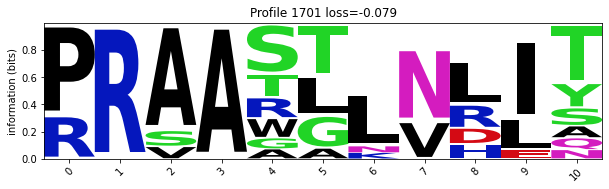

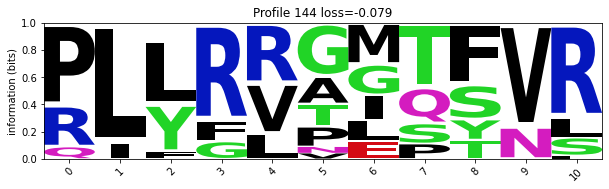

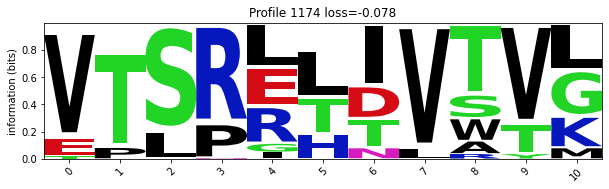

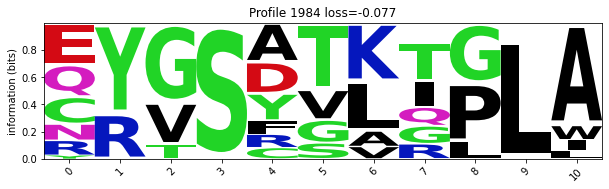

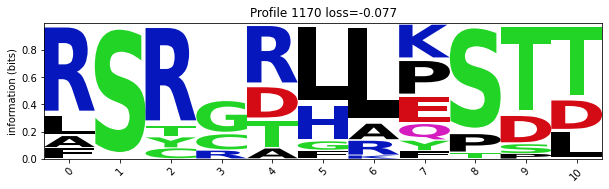

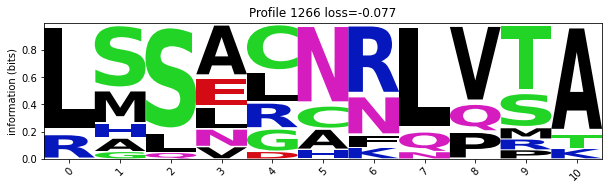

In [94]:
P = specProModel.getP()
#pScores = specProModel.max_profile_scores(ds_score)
#plotLogo(P=P, idxarray = np.argsort(-pScores), pScores=pScores, max_print=5)
pLosses = specProModel.min_profile_losses(ds_score)
plotLogo(P=P, idxarray = np.argsort(pLosses), pScores=pLosses, max_print=20, label="loss")

---

## Profile Score Distribution

In [95]:
def customHist(distType: str, prec = 1):
    validDistTypes = ['score', 'loss', 'L5score']
    assert distType in validDistTypes, "distType must be one of "+str(validDistTypes)
    
    collect = {}
    ds_score = getDataset().batch(batch_size).prefetch(150)
    for batch in ds_score:
        for X in batch:
            S, _, _ = specProModel(X)
            if distType == 'score':
                for s in np.array(S).flatten():
                    score = np.math.floor(s*prec)
                    if score not in collect:
                        collect[score] = 0
                        
                    collect[score] += 1
                    
            if distType == 'loss':
                _, LpU, _ = specProModel.loss(S)
                for l in LpU:
                    loss = np.math.floor(l*prec)
                    if loss not in collect:
                        collect[loss] = 0
                        
                    collect[loss] += 1
                    
            if distType == 'L5score':
                gamma = .2
                S2 = tf.nn.softmax(gamma*S, axis=0)
                S3 = tf.math.multiply(S, tf.square(S2))
                for s in np.array(S3).flatten():
                    score = np.math.floor(s*prec)
                    if score not in collect:
                        collect[score] = 0
                        
                    collect[score] += 1
                    
    fkeys = [k for k in collect.keys()]
    bins = [b for b in range(min(fkeys), max(fkeys)+1)]
    vals = [collect[k] if k in collect else 0 for k in bins]
    bins = [b/prec for b in bins]
    
    plt.bar(list(range(len(bins))), vals, tick_label=[str(b) for b in bins])
    
    return bins, vals

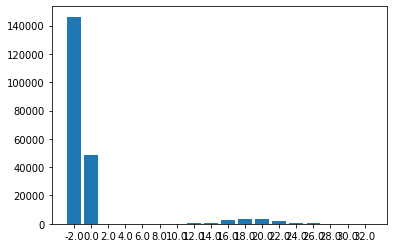

In [96]:
bins, vals = customHist('L5score', 0.5)

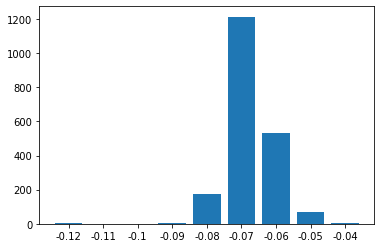

In [97]:
bins, vals = customHist('loss', 100)

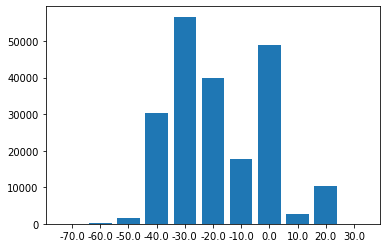

In [98]:
bins, vals = customHist('score', 0.1)

     P:     (k, alphSize, U) 
     X:     (tilesPerX, N, 6, T, alphSize) 
     Z:     (tilesPerX, N, 6, T-k+1, U)
     S:     (tilesPerX, N, U)

In [99]:
Scollect = []
Lcollect = []

ds_score = getDataset().batch(batch_size).prefetch(150)
for batch in ds_score:
    for X in batch:
        S, _, Z = specProModel(X)
        _, LpU, _ = specProModel.loss(S)
        Scollect.extend(np.array(S).flatten())
        Lcollect.extend(np.array(LpU).flatten())

(array([   99.,   216.,  8558., 50654., 45125., 33809., 56404.,   352.,
         9543.,  3240.]),
 array([-65.04354  , -55.25531  , -45.467075 , -35.678844 , -25.890614 ,
        -16.10238  ,  -6.314149 ,   3.4740834,  13.262316 ,  23.050547 ,
         32.83878  ], dtype=float32),
 <BarContainer object of 10 artists>)

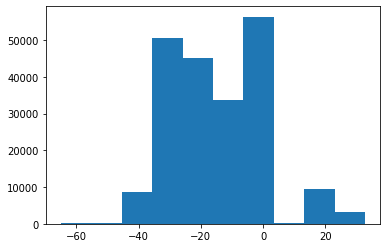

In [100]:
plt.hist(Scollect)

(array([  3.,   1.,   1.,   0.,  44., 822., 697., 363.,  62.,   7.]),
 array([-0.11769769, -0.10916521, -0.10063274, -0.09210027, -0.0835678 ,
        -0.07503532, -0.06650285, -0.05797038, -0.0494379 , -0.04090543,
        -0.03237296], dtype=float32),
 <BarContainer object of 10 artists>)

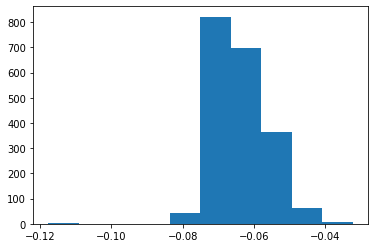

In [101]:
plt.hist(Lcollect)

TensorShape([8, 2000])

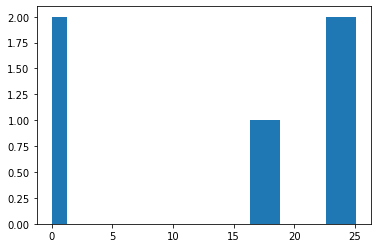

In [102]:
gamma = .01 # a small value means a more inclusive meaning of near-best
S2 = tf.nn.softmax(gamma*S, axis=0)
S3 = tf.reduce_max(S2, axis=0) # the closer to 1, the clearer is the champion match a winner
S4 = tf.reduce_max(S, axis=0) # ranges over tiles, or soft max like in L1
S5 = tf.math.multiply(S4, S3) # effectively the best score per genome is divided by the number of matches
loss_by_unit = tf.reduce_sum(S5, axis=0) / U # sum over genomes
L5 = tf.reduce_sum(loss_by_unit) # sum over profiles=units
plt.hist(S4[:,0].numpy().flatten(), bins=20)
S5.shape

---

### Profile Match Sites

In [107]:
ds_sites = getDataset(withPosTracking = True).batch(batch_size).prefetch(150)
sites = specProModel.get_profile_match_sites(ds_sites, 1, tile_size, genomes, False)
sites

{0: {0: {'profile': [1172], 'pos': [103], 'score': [32.83878], 'frame': [1]}},
 1: {0: {'profile': [1440],
   'pos': [6015],
   'score': [29.603613],
   'frame': [0]}},
 2: {0: {'profile': [646], 'pos': [887], 'score': [32.549397], 'frame': [3]}},
 3: {0: {'profile': [646], 'pos': [351], 'score': [32.35133], 'frame': [5]}},
 4: {0: {'profile': [1172], 'pos': [7768], 'score': [32.83878], 'frame': [1]}},
 5: {0: {'profile': [646], 'pos': [259], 'score': [32.24766], 'frame': [4]}},
 6: {0: {'profile': [646], 'pos': [379], 'score': [32.549397], 'frame': [4]}},
 7: {0: {'profile': [1172], 'pos': [2078], 'score': [32.83878], 'frame': [2]}}}

In [108]:
print(insertTracking)

{0: {0: {'pos': [102], 'pattern': ['ATGGCAAGAATTCAATCTACTGCAAATAAAGAA']}}, 1: {0: {'pos': [6007], 'pattern': ['ATGGCAAGAATTCAATCTACTGCAAATAAAGAA']}}, 2: {0: {'pos': [886], 'pattern': ['ATGGCAAGAATTCAATCTACTGCAAATAAAGAA']}}, 3: {0: {'pos': [5360], 'pattern': ['ATGGCAAGAATTCAATCTACTGCAAATAAAGAA']}}, 4: {0: {'pos': [7767], 'pattern': ['ATGGCAAGAATTCAATCTACTGCAAATAAAGAA']}}, 5: {0: {'pos': [6270], 'pattern': ['ATGGCAAGAATTCAATCTACTGCAAATAAAGAA']}}, 6: {0: {'pos': [8394], 'pattern': ['ATGGCAAGAATTCAATCTACTGCAAATAAAGAA']}}, 7: {0: {'pos': [2077], 'pattern': ['ATGGCAAGAATTCAATCTACTGCAAATAAAGAA']}}}


#### Visualize Profile Matches

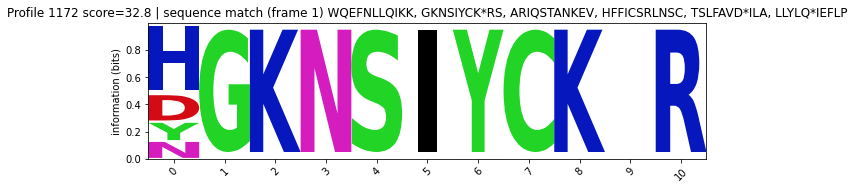

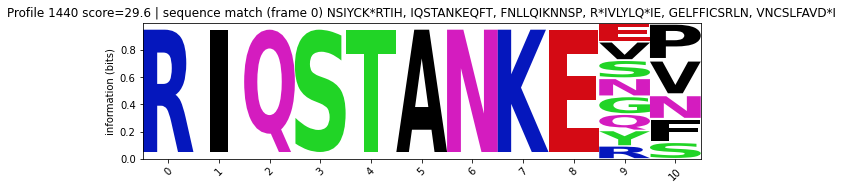

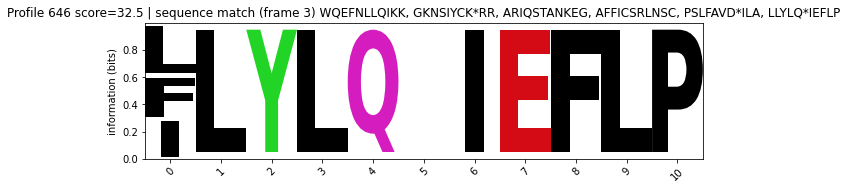

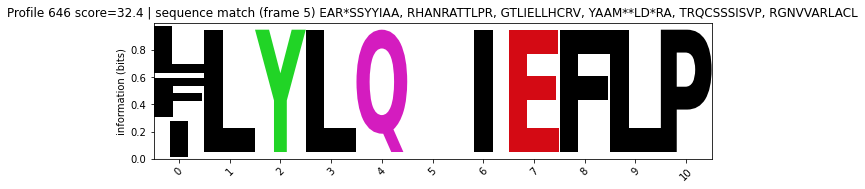

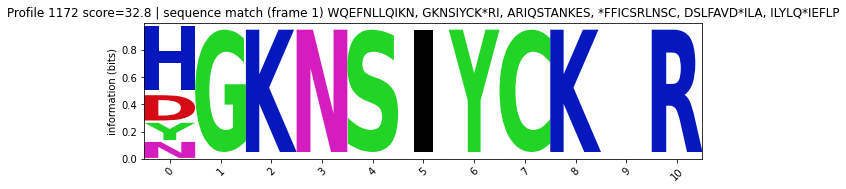

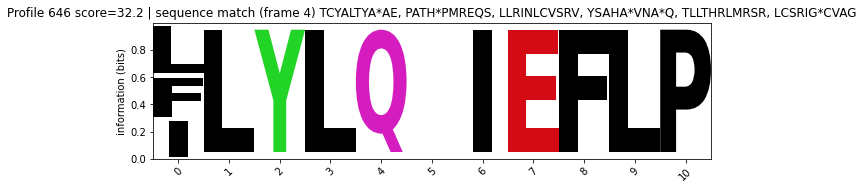

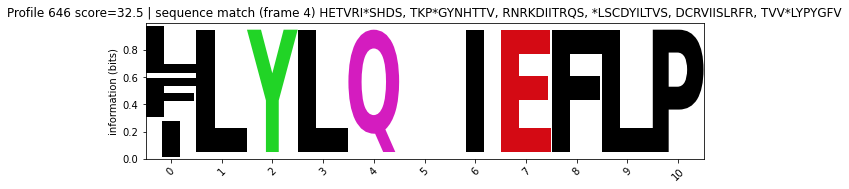

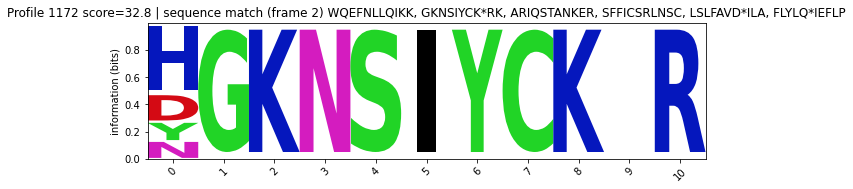

In [109]:
P = specProModel.getP()
for g in list(sites.keys()):
    for c in list(sites[g].keys()):
        gseq = genomes[g][c]
        for i in range(len(sites[g][c]['profile'])):
            p = sites[g][c]['profile'][i]
            pos = sites[g][c]['pos'][i]
            score = sites[g][c]['score'][i]
            f = sites[g][c]['frame'][i]
            
            match = gseq[pos:(pos+specProModel.k*3)+2]
            match_aa = su.six_frame_translation(match)
            profile_df = su.makeDFs(P[:,:,p:(p+1)].numpy())[0]
            logo = logomaker.Logo(profile_df, vpad=.1, width=1)
            logo.style_xticks(anchor=0, spacing=1, rotation=45)
            logo.ax.set_ylabel('information (bits)')
            logo.ax.set_title(f"Profile {p}" + (f" score={score:.1f}") + " | sequence match (frame "+str(f)+") "+', '.join(match_aa))

In [106]:
_, _ = printExpectedPatterns()

Desired: ['MARIQSTANKE', 'WQEFNLLQIK', 'GKNSIYCK*R', 'FFICSRLNSCH', 'SLFAVD*ILA', 'LYLQ*IEFLP']
Repeat: ['REPEATAEPER', 'ENLKLLLNLK', 'RT*SYC*T*K', 'SFRFSSSFRFS', 'LSGSAVASGS', 'FQVQQ*LQVL']


#### "Sensitivity" of Profile Matches

In [32]:
# ...

In [33]:
assert False # stop here

AssertionError: 

---

## Find Best Profiles

Idea: 
* convert profiles into aa-sequences (translate max. values into aa at each position)
* align (or perfect match?) sequences against the 6 possible pattern translations and the insert translations
* alignment scores give an idea of how good the profiles are -> allows multiple training runs to account for randomness, evaluate how good the profiles usually are (+ variance)

In [ ]:
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

In [ ]:
def runTraining():
    tf.keras.backend.clear_session() # avoid memory cluttering by remains of old models
    
    # build and randomly initialize profile model
    specProModel = SpecificProfile(k, su.aa_alphabet_size, U, Q)
    
    #start = time()
    specProModel.train_ds(ds, steps_per_epoch, epochs=500, verbose=False)
    #end = time()
    #print(f"time: {end-start:.2f}")
    
    #S, R = specProModel(X)
    #_, (L1, L2, L4, L7) = specProModel.loss(S)
    #pScores = tf.reduce_sum(tf.reduce_max(S,axis=0), axis=0).numpy()
    #print("pScores", pScores)
    #np.argsort(pScores)
    #print ("loss=", L1.numpy(), "\tL2=", L2.numpy(), 
    #       "\tL4=", L4.numpy(), "\nS=", S.numpy())
    
    P = specProModel.getP()
    
    return P

In [ ]:
def aaFromProfiles(P):
    profiles_aa = []
    for pidx in range(P.shape[2]):
        pmat = P[:,:,pidx]
        profiles_aa.append(su.to_aa_seq(pmat))

    return profiles_aa

In [ ]:
def getBestAlignments(profiles, patterns, scoreThreshold = int(k/2)):
    scores = []
    alignments = []
    best_profiles = []
    for profile in profiles:
        pscores = []
        palignments = []
        for pattern in patterns:
            als = pairwise2.align.localxd(profile, pattern, openA=-1000, extendA=-1000, openB=-1000, extendB=-1000)
            s = [al.score for al in als]
            if len(s) > 0:
                pscores.append(np.argmax(s))
                palignments.append(als[np.argmax(s)])

        best_al = palignments[np.argmax(pscores)]
        if best_al.score >= scoreThreshold:
            scores.append(best_al.score)
            alignments.append(best_al)
            best_profiles.append(profile)

    if len(scores) > 0:
        sortedIdx = np.argsort([-s for s in scores])
        scores = [scores[i] for i in sortedIdx]
        alignments = [alignments[i] for i in sortedIdx]
        best_profiles = [best_profiles[i] for i in sortedIdx]
    
    return scores, alignments, best_profiles

In [ ]:
if False:
    for i in range(20):
        P = runTraining()
        profiles = aaFromProfiles(P)
        print("Run", i)
        if insertPatterns is not None:
            print("Desired profiles:")
            patternScores, patternAlignments, patternProfiles = getBestAlignments(profiles, desiredPatternAA)
            for i in range(len(patternScores)):
                    print(patternProfiles[i])
                    print(format_alignment(*(patternAlignments[i])))

        if repeatPatterns is not None:
            print("Undesired profiles:")
            repeatScores, repeatAlignments, repeatProfiles = getBestAlignments(profiles, repeatPatternAA)
            for i in range(len(repeatScores)):
                    print(repeatProfiles[i])
                    print(format_alignment(*(repeatAlignments[i])))

        print("")
        print("-----")
        print("")
        
else:
    P = specProModel.getP()
    profiles = aaFromProfiles(P)

    if insertPatterns is not None:
        print("Desired profiles:")
        patternScores, patternAlignments, patternProfiles = getBestAlignments(profiles, desiredPatternAA, scoreThreshold=4)
        for i in range(len(patternScores)):
                print(patternProfiles[i])
                print(format_alignment(*(patternAlignments[i])))

    if repeatPatterns is not None:
        print("Undesired profiles:")
        repeatScores, repeatAlignments, repeatProfiles = getBestAlignments(profiles, repeatPatternAA, scoreThreshold=4)
        for i in range(len(repeatScores)):
            print(repeatProfiles[i])
            print(format_alignment(*(repeatAlignments[i])))

In [ ]:
R = specProModel.getR()
profiles = aaFromProfiles(R)
if insertPatterns is not None:
    print("Desired profiles:")
    patternScores, patternAlignments, patternProfiles = getBestAlignments(profiles, desiredPatternAA, scoreThreshold=4)
    for i in range(len(patternScores)):
            print(patternProfiles[i])
            print(format_alignment(*(patternAlignments[i])))

if repeatPatterns is not None:
    print("Undesired profiles:")
    repeatScores, repeatAlignments, repeatProfiles = getBestAlignments(profiles, repeatPatternAA, scoreThreshold=4)
    for i in range(len(repeatScores)):
        print(repeatProfiles[i])
        print(format_alignment(*(repeatAlignments[i])))